## In this notebook, we are going to set up a point to point link between two sites, and set up bridges that are inside the sites.

## We are going to let a node in one site ping the node in the other site through the bridges and the ptp link.

The path is first going to go from the origin node through the local bridge in the local site, then through the ptp link, then through the remote bridge in the remote site, then to the destination node.

In [9]:
import os
from fabrictestbed.slice_manager import SliceManager, Status
import json

In [10]:
credmgr_host = os.environ['FABRIC_CREDMGR_HOST']
orchestrator_host = os.environ['FABRIC_ORCHESTRATOR_HOST']
print(f"CM Host: {credmgr_host} Orchestrator Host: {orchestrator_host}")

CM Host: beta-2.fabric-testbed.net Orchestrator Host: beta-7.fabric-testbed.net


In [11]:
slice_manager = SliceManager(oc_host=orchestrator_host, cm_host=credmgr_host, project_name='all', scope='all')

# Initialize the slice manager
slice_manager.initialize()

In [30]:
status, advertised_topology = slice_manager.resources()

print(f"Status: {status}")
if status == Status.OK:
    print(f"Toplogy: {advertised_topology}")
else:
    print(f"Error: {advertised_topology}")

Status: Status.OK
Toplogy: LBNL: { cpu: 6/6 , core: 188/192 , ram: 1,524/1,536 G, disk: 9,580/9,600 G, unit: 3/3 }
	Components:
		NVME-P4510:  NVME P4510 { disk: 10,000/10,000 G, unit: 10/10 }
		GPU-RTX6000:  GPU RTX6000 { unit: 2/2 }
		GPU-Tesla T4:  GPU Tesla T4 { unit: 4/4 }
		SharedNIC-ConnectX-6:  SharedNIC ConnectX-6 { unit: 379/381 }
		SmartNIC-ConnectX-6:  SmartNIC ConnectX-6 { unit: 2/2 }
		SmartNIC-ConnectX-5:  SmartNIC ConnectX-5 { unit: 2/2 }
	Site Interfaces:
UKY: { cpu: 6/6 , core: 190/192 , ram: 1,530/1,536 G, disk: 9,590/9,600 G, unit: 3/3 }
	Components:
		SmartNIC-ConnectX-6:  SmartNIC ConnectX-6 { unit: 2/2 }
		SmartNIC-ConnectX-5:  SmartNIC ConnectX-5 { unit: 2/2 }
		GPU-RTX6000:  GPU RTX6000 { unit: 2/2 }
		GPU-Tesla T4:  GPU Tesla T4 { unit: 4/4 }
		NVME-P4510:  NVME P4510 { disk: 9,000/10,000 G, unit: 9/10 }
		SharedNIC-ConnectX-6:  SharedNIC ConnectX-6 { unit: 380/381 }
	Site Interfaces:
RENC
	Components:
		NVME-P4510:  NVME P4510 { disk: 10,000/10,000 G, unit: 1

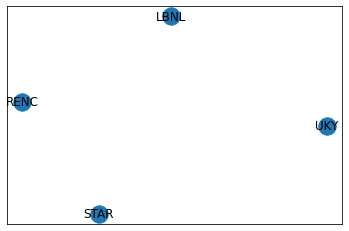

In [13]:
if status == Status.OK:
    advertised_topology.draw()

### You can take a look below at the configuration that we are going to request.

In [31]:
from fabrictestbed.slice_editor import ExperimentTopology, Capacities, ComponentType, ComponentModelType, ServiceType
# Create topology
t = ExperimentTopology()

# Set capacities
cap = Capacities()
cap.set_fields(core=2, ram=6, disk=10)

# Add node
n1 = t.add_node(name='n1', site='UKY')
# Set Properties
n1.set_properties(capacities=cap, image_type='qcow2', image_ref='default_ubuntu_20')

# Add node
nr1 = t.add_node(name='nr1', site='UKY')
# Set Properties
nr1.set_properties(capacities=cap, image_type='qcow2', image_ref='default_ubuntu_20')


# Add node
n2 = t.add_node(name='n2', site='LBNL')
# Set properties
n2.set_properties(capacities=cap, image_type='qcow2', image_ref='default_ubuntu_20')

# Add node
nr2 = t.add_node(name='nr2', site='LBNL')
# Set properties
nr2.set_properties(capacities=cap, image_type='qcow2', image_ref='default_ubuntu_20')

# Shared Cards
n1.add_component(model_type=ComponentModelType.SmartNIC_ConnectX_6, name='n1-nic1')
nr1.add_component(model_type=ComponentModelType.SmartNIC_ConnectX_6, name='nr1-nic1')
n2.add_component(model_type=ComponentModelType.SmartNIC_ConnectX_6, name='n2-nic1')
nr2.add_component(model_type=ComponentModelType.SmartNIC_ConnectX_6, name='nr2-nic1')


# L2PTP Service
t.add_network_service(name='ptp1', nstype=ServiceType.L2PTP, interfaces=[nr1.interface_list[0], nr2.interface_list[0]])

# L2Bridge Service
t.add_network_service(name='bridge1', nstype=ServiceType.L2Bridge, interfaces=[n1.interface_list[0], nr1.interface_list[1]])
# L2Bridge Service
t.add_network_service(name='bridge2', nstype=ServiceType.L2Bridge, interfaces=[n2.interface_list[0], nr2.interface_list[1]])


# Specify VLAN
if_labels = nr1.interface_list[0].get_property(pname="labels")
if_labels.vlan = "200"
nr1.interface_list[0].set_properties(labels=if_labels)

if_labels = nr2.interface_list[0].get_property(pname="labels")
if_labels.vlan = "200"
nr2.interface_list[0].set_properties(labels=if_labels)


# Generate Slice Graph
slice_graph = t.serialize()

t.interface_list

ssh_key = None
with open ("/home/fabric/.ssh/id_rsa.pub", "r") as myfile:
    ssh_key=myfile.read()
    ssh_key=ssh_key.strip()

# Request slice from Orchestrator
status, reservations = slice_manager.create(slice_name='Slice-l2p2p-ded', slice_graph=slice_graph, ssh_key=ssh_key)

print("Response Status {}".format(status))
if status == Status.OK:
    print("Reservations created {}".format(reservations))
else:
    print(f"Failure: {reservations}")

Response Status Status.OK
Reservations created [{
    "graph_node_id": "9e1656f4-91db-4463-891f-8b12af4fd4b1",
    "lease_end": "2021-09-06 00:40:09",
    "pending_state": "None_",
    "reservation_id": "127d202f-e785-41c0-ba87-6495b7eb1493",
    "reservation_state": "Unknown",
    "slice_id": "116150b3-f185-412e-bd0b-3e922d06a785"
}, {
    "graph_node_id": "8b445611-63e2-4330-80df-0b1fd61fa4a7",
    "lease_end": "2021-09-06 00:40:09",
    "pending_state": "None_",
    "reservation_id": "f5ba3a55-43bf-4e77-8416-0c7c6809bd16",
    "reservation_state": "Unknown",
    "slice_id": "116150b3-f185-412e-bd0b-3e922d06a785"
}, {
    "graph_node_id": "e32812c5-c663-4ed3-8d9a-667b5d8a8980",
    "lease_end": "2021-09-06 00:40:09",
    "pending_state": "None_",
    "reservation_id": "8d4cc800-239e-4751-b492-af10f4992c29",
    "reservation_state": "Unknown",
    "slice_id": "116150b3-f185-412e-bd0b-3e922d06a785"
}, {
    "graph_node_id": "7421d22f-dfb7-4153-97ef-178e1bd0766a",
    "lease_end": "2021

### Below is the configuration in image form.

<img src="FABRIC experiment ptp link and two bridges.png">

### Let's take a look at the interfaces that we have.

In [32]:
t.interface_list

({'capacities': '{ bw: 100 Gbps, unit: 1 }', 'labels': '{ local_name: p1}', 'name': 'n1-nic1-p1', 'type': 'DedicatedPort'},
 {'capacities': '{ bw: 100 Gbps, unit: 1 }', 'labels': '{ local_name: p2}', 'name': 'n1-nic1-p2', 'type': 'DedicatedPort'},
 {'capacities': '{ bw: 100 Gbps, unit: 1 }', 'labels': '{ vlan: 200, local_name: p1}', 'name': 'nr1-nic1-p1', 'type': 'DedicatedPort'},
 {'capacities': '{ bw: 100 Gbps, unit: 1 }', 'labels': '{ local_name: p2}', 'name': 'nr1-nic1-p2', 'type': 'DedicatedPort'},
 {'capacities': '{ bw: 100 Gbps, unit: 1 }', 'labels': '{ local_name: p1}', 'name': 'n2-nic1-p1', 'type': 'DedicatedPort'},
 {'capacities': '{ bw: 100 Gbps, unit: 1 }', 'labels': '{ local_name: p2}', 'name': 'n2-nic1-p2', 'type': 'DedicatedPort'},
 {'capacities': '{ bw: 100 Gbps, unit: 1 }', 'labels': '{ vlan: 200, local_name: p1}', 'name': 'nr2-nic1-p1', 'type': 'DedicatedPort'},
 {'capacities': '{ bw: 100 Gbps, unit: 1 }', 'labels': '{ local_name: p2}', 'name': 'nr2-nic1-p2', 'type': 

In [33]:
nr1.interface_list[0]

{'capacities': '{ bw: 100 Gbps, unit: 1 }', 'labels': '{ vlan: 200, local_name: p1}', 'name': 'nr1-nic1-p1', 'type': 'DedicatedPort'}

In [34]:
nr2.interface_list[0]

{'capacities': '{ bw: 100 Gbps, unit: 1 }', 'labels': '{ vlan: 200, local_name: p1}', 'name': 'nr2-nic1-p1', 'type': 'DedicatedPort'}

In [35]:
# Set the Slice ID from output of the above command
slice_id=reservations[0].slice_id

## Query Slivers

In [37]:
status, slivers = slice_manager.slivers(slice_id=slice_id)

print("Response Status {}".format(status))
if status == Status.OK:
    print("Slivers {}".format(slivers))
else:
    print(f"Failure: {slivers}")

Response Status Status.OK
Slivers [{
    "allocated_capacities": "{\"core\": 2, \"disk\": 10, \"ram\": 8}",
    "allocated_labels": "{\"instance\": \"instance-000001af\", \"instance_parent\": \"lbnl-w2.fabric-testbed.net\"}",
    "capacities": "{\"core\": 2, \"disk\": 10, \"ram\": 6}",
    "capacity_hints": "{\"instance_type\": \"fabric.c2.m8.d10\"}",
    "graph_node_id": "7421d22f-dfb7-4153-97ef-178e1bd0766a",
    "join_state": "NoJoin",
    "lease_end": "2021-09-06 00:40:09",
    "management_ip": "198.129.61.53",
    "name": "nr2",
    "pending_state": "None_",
    "reservation_id": "118c5d3c-e07d-4d0f-887b-7d6ccac8352d",
    "reservation_state": "Active",
    "resource_type": "VM",
    "site": "LBNL",
    "slice_id": "116150b3-f185-412e-bd0b-3e922d06a785"
}, {
    "allocated_capacities": "{\"core\": 2, \"disk\": 10, \"ram\": 8}",
    "allocated_labels": "{\"instance\": \"instance-0000031b\", \"instance_parent\": \"uky-w2.fabric-testbed.net\"}",
    "capacities": "{\"core\": 2, \"dis

## Sliver Status

In [39]:
for s in slivers:
    status, sliver_status = slice_manager.sliver_status(slice_id=slice_id, sliver_id=s.reservation_id)

    print("Response Status {}".format(status))
    if status == Status.OK:
        print()
        print("Sliver Status {}".format(sliver_status))
        print()

Response Status Status.OK

Sliver Status {
    "allocated_capacities": "{\"core\": 2, \"disk\": 10, \"ram\": 8}",
    "allocated_labels": "{\"instance\": \"instance-000001af\", \"instance_parent\": \"lbnl-w2.fabric-testbed.net\"}",
    "capacities": "{\"core\": 2, \"disk\": 10, \"ram\": 6}",
    "capacity_hints": "{\"instance_type\": \"fabric.c2.m8.d10\"}",
    "graph_node_id": "7421d22f-dfb7-4153-97ef-178e1bd0766a",
    "join_state": "NoJoin",
    "lease_end": "2021-09-06 00:40:09",
    "management_ip": "198.129.61.53",
    "name": "nr2",
    "notices": "Reservation 118c5d3c-e07d-4d0f-887b-7d6ccac8352d (Slice Slice-l2p2p-ded(116150b3-f185-412e-bd0b-3e922d06a785) Graph Id:d1dac440-e2c0-41d8-a235-95ed0f8eef1f Owner:name: orchestrator guid: orchestrator-guid email: minawm@bu.edu State:StableOK ) is in state [Active,None_]\n\nLast ticket update: \nTicket events: \nLast ticket update: \nTicket events: ",
    "pending_state": "None_",
    "reservation_id": "118c5d3c-e07d-4d0f-887b-7d6ccac83

### Now let's connect to the nodes.

In [40]:
import paramiko

In [41]:
n1_ip = list(filter(lambda sliver : sliver.name == "n1",slivers))[0].management_ip
n1_ip

'128.163.179.59'

In [42]:
nr1_ip = list(filter(lambda sliver : sliver.name == "nr1",slivers))[0].management_ip
nr1_ip

'128.163.179.23'

In [43]:
n2_ip = list(filter(lambda sliver : sliver.name == "n2",slivers))[0].management_ip
n2_ip

'198.129.61.54'

In [44]:
nr2_ip = list(filter(lambda sliver : sliver.name == "nr2",slivers))[0].management_ip
nr2_ip

'198.129.61.53'

In [45]:
key = paramiko.RSAKey.from_private_key_file("/home/fabric/.ssh/id_rsa")
clientn1 = paramiko.SSHClient()
clientn1.load_system_host_keys()
clientn1.set_missing_host_key_policy(paramiko.MissingHostKeyPolicy())

clientn1.set_missing_host_key_policy(paramiko.AutoAddPolicy())
clientn1.connect(n1_ip,username='ubuntu',pkey = key)

clientn1

In [46]:
key = paramiko.RSAKey.from_private_key_file("/home/fabric/.ssh/id_rsa")
clientnr1 = paramiko.SSHClient()
clientnr1.load_system_host_keys()
clientnr1.set_missing_host_key_policy(paramiko.MissingHostKeyPolicy())

clientnr1.set_missing_host_key_policy(paramiko.AutoAddPolicy())
clientnr1.connect(nr1_ip,username='ubuntu',pkey = key)

clientnr1

In [47]:
key = paramiko.RSAKey.from_private_key_file("/home/fabric/.ssh/id_rsa")
clientn2 = paramiko.SSHClient()
clientn2.load_system_host_keys()
clientn2.set_missing_host_key_policy(paramiko.MissingHostKeyPolicy())

clientn2.set_missing_host_key_policy(paramiko.AutoAddPolicy())
clientn2.connect(n2_ip,username='ubuntu',pkey = key)

clientn2

In [48]:
key = paramiko.RSAKey.from_private_key_file("/home/fabric/.ssh/id_rsa")
clientnr2 = paramiko.SSHClient()
clientnr2.load_system_host_keys()
clientnr2.set_missing_host_key_policy(paramiko.MissingHostKeyPolicy())

clientnr2.set_missing_host_key_policy(paramiko.AutoAddPolicy())
clientnr2.connect(nr2_ip,username='ubuntu',pkey = key)

clientnr2

### First, let's install some tools that we will need.

In [49]:
stdin, stdout, stderr = clientnr1.exec_command('sudo apt update && sudo apt install net-tools && sudo apt install traceroute')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))
stdin, stdout, stderr = clientnr2.exec_command('sudo apt update && sudo apt install net-tools && sudo apt install traceroute')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))
stdin, stdout, stderr = clientn1.exec_command('sudo apt update && sudo apt install net-tools && sudo apt install traceroute')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))
stdin, stdout, stderr = clientn2.exec_command('sudo apt update && sudo apt install net-tools && sudo apt install traceroute')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Get:1 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:2 http://nova.clouds.archive.ubuntu.com/ubuntu focal InRelease
Get:3 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [830 kB]
Get:4 http://nova.clouds.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:5 http://nova.clouds.archive.ubuntu.com/ubuntu focal-backports InRelease [101 kB]
Get:6 http://security.ubuntu.com/ubuntu focal-security/main Translation-en [162 kB]
Get:7 http://security.ubuntu.com/ubuntu focal-security/main amd64 c-n-f Metadata [8604 B]
Get:8 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [374 kB]
Get:9 http://security.ubuntu.com/ubuntu focal-security/restricted Translation-en [53.7 kB]
Get:10 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 c-n-f Metadata [500 B]
Get:11 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [638 kB]
Get:12 http://security.ubuntu.com/ubuntu focal-security/universe 

### Now, our task is to configure the ptp link and the bridges.

### Let's first configure the ptp link. Let's look at the interfaces of `nr1` and `nr2`.

In [50]:
stdin, stdout, stderr = clientnr1.exec_command('ip a')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

1: lo: <LOOPBACK,UP,LOWER_UP> mtu 65536 qdisc noqueue state UNKNOWN group default qlen 1000
    link/loopback 00:00:00:00:00:00 brd 00:00:00:00:00:00
    inet 127.0.0.1/8 scope host lo
       valid_lft forever preferred_lft forever
    inet6 ::1/128 scope host 
       valid_lft forever preferred_lft forever
2: ens3: <BROADCAST,MULTICAST,UP,LOWER_UP> mtu 9000 qdisc fq_codel state UP group default qlen 1000
    link/ether fa:16:3e:3a:01:2c brd ff:ff:ff:ff:ff:ff
    inet 10.20.4.232/24 brd 10.20.4.255 scope global dynamic ens3
       valid_lft 86171sec preferred_lft 86171sec
    inet6 fe80::f816:3eff:fe3a:12c/64 scope link 
       valid_lft forever preferred_lft forever
3: ens7: <BROADCAST,MULTICAST> mtu 1500 qdisc noop state DOWN group default qlen 1000
    link/ether 0c:42:a1:78:f8:04 brd ff:ff:ff:ff:ff:ff
4: ens8: <BROADCAST,MULTICAST> mtu 1500 qdisc noop state DOWN group default qlen 1000
    link/ether 0c:42:a1:78:f8:05 brd ff:ff:ff:ff:ff:ff




In [51]:
stdin, stdout, stderr = clientnr2.exec_command('ip a')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

1: lo: <LOOPBACK,UP,LOWER_UP> mtu 65536 qdisc noqueue state UNKNOWN group default qlen 1000
    link/loopback 00:00:00:00:00:00 brd 00:00:00:00:00:00
    inet 127.0.0.1/8 scope host lo
       valid_lft forever preferred_lft forever
    inet6 ::1/128 scope host 
       valid_lft forever preferred_lft forever
2: ens3: <BROADCAST,MULTICAST,UP,LOWER_UP> mtu 9000 qdisc fq_codel state UP group default qlen 1000
    link/ether fa:16:3e:3d:83:b4 brd ff:ff:ff:ff:ff:ff
    inet 10.20.4.78/24 brd 10.20.4.255 scope global dynamic ens3
       valid_lft 86174sec preferred_lft 86174sec
    inet6 fe80::f816:3eff:fe3d:83b4/64 scope link 
       valid_lft forever preferred_lft forever
3: ens7: <BROADCAST,MULTICAST> mtu 1500 qdisc noop state DOWN group default qlen 1000
    link/ether 04:3f:72:b7:18:ac brd ff:ff:ff:ff:ff:ff
4: ens8: <BROADCAST,MULTICAST> mtu 1500 qdisc noop state DOWN group default qlen 1000
    link/ether 04:3f:72:b7:18:ad brd ff:ff:ff:ff:ff:ff




### We have specified that we want the ptp link to connect the first port of `nr1`'s NIC (which is `ens7`) to the first port of `nr2`'s NIC (which is also `ens7`).

To configure the bridge, we need to work with tags. And to do that, we need to create a new interface (an example name that we will use: `ens7.200`) and activate it and activate it, along with its base interface.

### First, let's configure `nr1`'s side of the bridge. See the commands below.

In [52]:
stdin, stdout, stderr = clientnr1.exec_command('sudo ip link add link ens7 name ens7.200 type vlan id 200')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [53]:
stdin, stdout, stderr = clientnr1.exec_command('sudo ip link set dev ens7 up')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [54]:
stdin, stdout, stderr = clientnr1.exec_command('sudo ip link set dev ens7.200 up')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [55]:
stdin, stdout, stderr = clientnr1.exec_command('sudo ip addr add 192.168.10.51/24 dev ens7.200')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

<hr>

### Now, let's configure `nr2`'s side of the bridge. See the commands below.

In [56]:
stdin, stdout, stderr = clientnr2.exec_command('sudo ip link add link ens7 name ens7.200 type vlan id 200')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [57]:
stdin, stdout, stderr = clientnr2.exec_command('sudo ip link set dev ens7 up')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [58]:
stdin, stdout, stderr = clientnr2.exec_command('sudo ip link set dev ens7.200 up')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [59]:
stdin, stdout, stderr = clientnr2.exec_command('sudo ip addr add 192.168.10.52/24 dev ens7.200')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

<hr>

### Now the p2p link should be working. Let's ping.

In [60]:
stdin, stdout, stderr = clientnr1.exec_command('ping -c 5 192.168.10.52')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 192.168.10.52 (192.168.10.52) 56(84) bytes of data.
64 bytes from 192.168.10.52: icmp_seq=1 ttl=64 time=113 ms
64 bytes from 192.168.10.52: icmp_seq=2 ttl=64 time=56.3 ms
64 bytes from 192.168.10.52: icmp_seq=3 ttl=64 time=56.3 ms
64 bytes from 192.168.10.52: icmp_seq=4 ttl=64 time=56.3 ms
64 bytes from 192.168.10.52: icmp_seq=5 ttl=64 time=56.3 ms

--- 192.168.10.52 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4005ms
rtt min/avg/max/mdev = 56.331/67.638/112.847/22.604 ms




In [61]:
stdin, stdout, stderr = clientnr2.exec_command('ping -c 5 192.168.10.51')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 192.168.10.51 (192.168.10.51) 56(84) bytes of data.
64 bytes from 192.168.10.51: icmp_seq=1 ttl=64 time=56.5 ms
64 bytes from 192.168.10.51: icmp_seq=2 ttl=64 time=56.3 ms
64 bytes from 192.168.10.51: icmp_seq=3 ttl=64 time=56.3 ms
64 bytes from 192.168.10.51: icmp_seq=4 ttl=64 time=56.3 ms
64 bytes from 192.168.10.51: icmp_seq=5 ttl=64 time=56.3 ms

--- 192.168.10.51 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4006ms
rtt min/avg/max/mdev = 56.315/56.363/56.505/0.071 ms




### We can see that the p2p link is working. We have finished setting up the p2p link between `nr1` and `nr2`.

## Now let's configure the bridges. We have a bridge between `n1` and `nr1`, and a bridge between `n2` and `nr2`.

### We have specified that we want a bridge to connect the first port of `n1` (which is `ens7`) to the second port of `nr1` (which is `ens8`).

### And we have specified that we want a bridge to connect the first port of `n2` (which is `ens7`) to the second port of `nr2` (which is `ens8`).

### For every interface on the two ends of the bridge, we need add an IP address, and activate the interface.

So for example, we add the IP address `192.168.11.53` to the interface `ens7` on `n1` by issuing the command: `sudo ip addr add 192.168.11.53/24 dev ens7`.

And we activate the interface `ens7` by issuing the command `sudo ip link set dev ens7 up`.

In [62]:
stdin, stdout, stderr = clientn1.exec_command('sudo ip addr add 192.168.11.53/24 dev ens7')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [63]:
stdin, stdout, stderr = clientn1.exec_command('sudo ip link set dev ens7 up')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

<hr>

In [64]:
stdin, stdout, stderr = clientnr1.exec_command('sudo ip addr add 192.168.11.51/24 dev ens8')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [65]:
stdin, stdout, stderr = clientnr1.exec_command('sudo ip link set dev ens8 up')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

### Now let's ping.

In [66]:
stdin, stdout, stderr = clientn1.exec_command('ping -c 5 192.168.11.51')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 192.168.11.51 (192.168.11.51) 56(84) bytes of data.
64 bytes from 192.168.11.51: icmp_seq=1 ttl=64 time=0.500 ms
64 bytes from 192.168.11.51: icmp_seq=2 ttl=64 time=0.065 ms
64 bytes from 192.168.11.51: icmp_seq=3 ttl=64 time=0.067 ms
64 bytes from 192.168.11.51: icmp_seq=4 ttl=64 time=0.100 ms
64 bytes from 192.168.11.51: icmp_seq=5 ttl=64 time=0.064 ms

--- 192.168.11.51 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4082ms
rtt min/avg/max/mdev = 0.064/0.159/0.500/0.170 ms




In [67]:
stdin, stdout, stderr = clientnr1.exec_command('ping -c 5 192.168.11.53')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 192.168.11.53 (192.168.11.53) 56(84) bytes of data.
64 bytes from 192.168.11.53: icmp_seq=1 ttl=64 time=0.146 ms
64 bytes from 192.168.11.53: icmp_seq=2 ttl=64 time=0.100 ms
64 bytes from 192.168.11.53: icmp_seq=3 ttl=64 time=0.077 ms
64 bytes from 192.168.11.53: icmp_seq=4 ttl=64 time=0.059 ms
64 bytes from 192.168.11.53: icmp_seq=5 ttl=64 time=0.055 ms

--- 192.168.11.53 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4101ms
rtt min/avg/max/mdev = 0.055/0.087/0.146/0.033 ms




### We can see that the two nodes can ping each other. The link between `n1` and `nr1` is set.

### Now let's do the same thing for `n2` and `nr2`.

In [68]:
stdin, stdout, stderr = clientn2.exec_command('sudo ip addr add 192.168.12.54/24 dev ens7')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [69]:
stdin, stdout, stderr = clientn2.exec_command('sudo ip link set dev ens7 up')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

<hr>

In [70]:
stdin, stdout, stderr = clientnr2.exec_command('sudo ip addr add 192.168.12.52/24 dev ens8')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [71]:
stdin, stdout, stderr = clientnr2.exec_command('sudo ip link set dev ens8 up')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

### Now let's ping.

In [72]:
stdin, stdout, stderr = clientn2.exec_command('ping -c 5 192.168.12.52')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 192.168.12.52 (192.168.12.52) 56(84) bytes of data.
64 bytes from 192.168.12.52: icmp_seq=1 ttl=64 time=0.265 ms
64 bytes from 192.168.12.52: icmp_seq=2 ttl=64 time=0.084 ms
64 bytes from 192.168.12.52: icmp_seq=3 ttl=64 time=0.074 ms
64 bytes from 192.168.12.52: icmp_seq=4 ttl=64 time=0.075 ms
64 bytes from 192.168.12.52: icmp_seq=5 ttl=64 time=0.082 ms

--- 192.168.12.52 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4083ms
rtt min/avg/max/mdev = 0.074/0.116/0.265/0.074 ms




In [73]:
stdin, stdout, stderr = clientnr2.exec_command('ping -c 5 192.168.12.54')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 192.168.12.54 (192.168.12.54) 56(84) bytes of data.
64 bytes from 192.168.12.54: icmp_seq=1 ttl=64 time=0.067 ms
64 bytes from 192.168.12.54: icmp_seq=2 ttl=64 time=0.049 ms
64 bytes from 192.168.12.54: icmp_seq=3 ttl=64 time=0.059 ms
64 bytes from 192.168.12.54: icmp_seq=4 ttl=64 time=0.066 ms
64 bytes from 192.168.12.54: icmp_seq=5 ttl=64 time=0.083 ms

--- 192.168.12.54 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4077ms
rtt min/avg/max/mdev = 0.049/0.064/0.083/0.011 ms




### The link between `n2` and `nr2` is set.

## We have set up each of the links that are between each two nodes. Now we want `n1` and `n2` to be able to reach each other through `nr1` and `nr2`.

First, we need to let `nr1` and `nr2` forward packets. We can do that by issuing the command

`sudo sysctl -w net.ipv4.ip_forward=1`.

In [94]:
stdin, stdout, stderr = clientnr1.exec_command('sudo sysctl -w net.ipv4.ip_forward=1')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

net.ipv4.ip_forward = 1




In [77]:
stdin, stdout, stderr = clientnr2.exec_command('sudo sysctl -w net.ipv4.ip_forward=1')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

net.ipv4.ip_forward = 1




### Next, we need to setup the routes.

In [78]:
stdin, stdout, stderr = clientn1.exec_command('sudo ip route add 192.168.12.0/24 via 192.168.11.51')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [79]:
stdin, stdout, stderr = clientn2.exec_command('sudo ip route add 192.168.11.0/24 via 192.168.12.52')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [109]:
stdin, stdout, stderr = clientnr1.exec_command('sudo ip route add 192.168.12.0/24 via 192.168.10.52')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [110]:
stdin, stdout, stderr = clientnr2.exec_command('sudo ip route add 192.168.11.0/24 via 192.168.10.51')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

### Now let's ping.

In [111]:
stdin, stdout, stderr = clientn1.exec_command('ping -c 5 192.168.12.54')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 192.168.12.54 (192.168.12.54) 56(84) bytes of data.
64 bytes from 192.168.12.54: icmp_seq=1 ttl=62 time=56.6 ms
64 bytes from 192.168.12.54: icmp_seq=2 ttl=62 time=56.4 ms
64 bytes from 192.168.12.54: icmp_seq=3 ttl=62 time=56.4 ms
64 bytes from 192.168.12.54: icmp_seq=4 ttl=62 time=56.5 ms
64 bytes from 192.168.12.54: icmp_seq=5 ttl=62 time=56.5 ms

--- 192.168.12.54 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4006ms
rtt min/avg/max/mdev = 56.418/56.460/56.550/0.047 ms




In [112]:
stdin, stdout, stderr = clientn2.exec_command('ping -c 5 192.168.11.53')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 192.168.11.53 (192.168.11.53) 56(84) bytes of data.
64 bytes from 192.168.11.53: icmp_seq=1 ttl=62 time=56.4 ms
64 bytes from 192.168.11.53: icmp_seq=2 ttl=62 time=56.4 ms
64 bytes from 192.168.11.53: icmp_seq=3 ttl=62 time=56.4 ms
64 bytes from 192.168.11.53: icmp_seq=4 ttl=62 time=56.4 ms
64 bytes from 192.168.11.53: icmp_seq=5 ttl=62 time=56.4 ms

--- 192.168.11.53 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4006ms
rtt min/avg/max/mdev = 56.418/56.430/56.447/0.009 ms




### We can see that `n1` and `n2` can reach each other.

### Now let's traceroute.

In [113]:
stdin, stdout, stderr = clientn1.exec_command('traceroute 192.168.12.54')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

traceroute to 192.168.12.54 (192.168.12.54), 30 hops max, 60 byte packets
 1  192.168.11.51 (192.168.11.51)  0.120 ms  0.103 ms  0.098 ms
 2  192.168.10.52 (192.168.10.52)  56.377 ms  56.372 ms  56.367 ms
 3  192.168.12.54 (192.168.12.54)  56.453 ms  56.405 ms  56.400 ms




In [114]:
stdin, stdout, stderr = clientn2.exec_command('traceroute 192.168.11.53')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

traceroute to 192.168.11.53 (192.168.11.53), 30 hops max, 60 byte packets
 1  192.168.12.52 (192.168.12.52)  0.052 ms  0.052 ms  0.035 ms
 2  192.168.10.51 (192.168.10.51)  56.365 ms  56.358 ms  56.352 ms
 3  192.168.11.53 (192.168.11.53)  56.395 ms  56.408 ms  56.382 ms




### You can see the hops.

For `n1` to reach `n2`, it first passes by `nr1` (which is `192.168.11.51`), then it passes by `nr2` (which is `192.168.10.52`), and finally it reaches `n2` (which is `192.168.12.54`).

For `n2` to reach `n1`, it first passes by `nr2` (which is `192.168.12.52`), then it passes by `nr1` (which is `192.168.10.51`), and finally it reaches `n1` (which is `192.168.11.53`).

### Finally, you can delete the slice using the cell below.

In [ ]:
status, result = slice_manager.delete(slice_id=slice_id)

print("Response Status {}".format(status))
print("Response received {}".format(result))